# Install and Load Libraries/Data

In [57]:
#!pip install /kaggle/input/skorch-whl-files/Skorch_WHL_Files/skorch-1.0.0-py3-none-any.whl
#!pip install skorch
#!pip install optuna

In [58]:
import os
import random
from concurrent.futures import ThreadPoolExecutor
from glob import glob
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             cohen_kappa_score, confusion_matrix, make_scorer, 
                             roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     train_test_split, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, 
                                    OrdinalEncoder, StandardScaler, label_binarize)
from sklearn.utils.class_weight import compute_class_weight
from skorch import NeuralNetClassifier
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import optuna

# Set the seed for reproducibility
def set_seed(seed=22):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(22)

os.environ["PYTHONWARNINGS"] = "ignore"

In [22]:
train_csv_path = './data/train.csv'
test_csv_path = './data/test.csv'
series_train_path = './data/series_train.parquet'
series_test_path = './data/series_test.parquet'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
train_df = train_df[train_df['sii'].notna()].copy()

In [23]:
# Drop rows where 'sii' is NaN
train_df = train_df[train_df['sii'].notna()].copy()

# Feature Engineering

In [24]:
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    df['SDS_InternetHours'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    return df

In [25]:
feature_engineering(train_df)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,SDS_InternetHours
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1564.977430,108.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008,1774.357653,0.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,90468.027355,135701.701175,11.862478,17.793672,0.594629,2.621003,0.562625,0.521399,1626.436495,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,...,15184.201563,25813.157324,15.405804,26.189881,0.385990,5.416433,0.546400,0.700249,1114.087619,116.0
3954,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,...,1367.006219,1777.103699,20.735773,26.956438,0.373066,43.676843,0.644749,0.667565,1044.525455,0.0
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,13985.687504,23775.715110,14.646602,24.899272,0.500487,12.939628,0.641165,0.631642,1145.372220,50.0
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,42623.022658,68197.040233,11.418397,18.269490,0.479653,4.334530,0.496020,0.623919,2122.708500,0.0


In [26]:
feature_engineering(test_df)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,BMI_PHR,SDS_InternetHours
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492,982.491320,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1564.977430,108.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008,1774.357653,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,90468.027355,135701.701175,11.862478,17.793672,0.594629,2.621003,0.562625,0.521399,1626.436495,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,24254.018580,38806.515140,13.426241,21.482033,0.476285,5.278294,0.558169,0.654233,1631.843107,120.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,19172.581896,30676.066044,14.014727,22.423515,0.485536,8.840947,0.599486,0.565344,1517.515782,NaN
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Imputing Missing Values for Non-Parquet Training Data

In [27]:
# Display Entire List of Missing Values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0] 
print(missing_values.to_string()) 

CGAS-Season                                394
CGAS-CGAS_Score                            394
Physical-Season                            141
Physical-BMI                               209
Physical-Height                            206
Physical-Weight                            164
Physical-Waist_Circumference              2253
Physical-Diastolic_BP                      258
Physical-HeartRate                         250
Physical-Systolic_BP                       258
Fitness_Endurance-Season                  1476
Fitness_Endurance-Max_Stage               2005
Fitness_Endurance-Time_Mins               2008
Fitness_Endurance-Time_Sec                2008
FGC-Season                                  89
FGC-FGC_CU                                 817
FGC-FGC_CU_Zone                            852
FGC-FGC_GSND                              1864
FGC-FGC_GSND_Zone                         1872
FGC-FGC_GSD                               1865
FGC-FGC_GSD_Zone                          1872
FGC-FGC_PU   

In [28]:
features = train_df.drop(columns=['id', 'sii'])
target = train_df['sii']

In [29]:
# Numerical Columns
numerical_cols = [
    'Basic_Demos-Age',
    'CGAS-CGAS_Score',
    'Physical-BMI',
    'Physical-Height',
    'Physical-Weight',
    'Physical-Waist_Circumference',
    'Physical-Diastolic_BP',
    'Physical-HeartRate',
    'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU',
    'FGC-FGC_GSND',
    'FGC-FGC_GSD',
    'FGC-FGC_PU',
    'FGC-FGC_SRL',
    'FGC-FGC_SRR',
    'FGC-FGC_TL',
    'BIA-BIA_BMC',
    'BIA-BIA_BMI',
    'BIA-BIA_BMR',
    'BIA-BIA_DEE',
    'BIA-BIA_ECW',
    'BIA-BIA_FFM',
    'BIA-BIA_FFMI',
    'BIA-BIA_FMI',
    'BIA-BIA_Fat',
    'BIA-BIA_ICW',
    'BIA-BIA_LDM',
    'BIA-BIA_LST',
    'BIA-BIA_SMM',
    'BIA-BIA_TBW',
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total',
    'PCIAT-PCIAT_Total',
    'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T',
    'PCIAT-PCIAT_01',
    'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03',
    'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07',
    'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09',
    'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11',
    'PCIAT-PCIAT_12',
    'PCIAT-PCIAT_13',
    'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15',
    'PCIAT-PCIAT_16',
    'PCIAT-PCIAT_17',
    'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19',
    'PCIAT-PCIAT_20',
    'BMI_Age',
    'Internet_Hours_Age',
    'BMI_Internet_Hours',
    'BFP_BMI',
    'FFMI_BFP',
    'FMI_BFP',
    'LST_TBW',
    'BFP_BMR',
    'BFP_DEE',
    'BMR_Weight',
    'DEE_Weight',
    'SMM_Height',
    'Muscle_to_Fat',
    'Hydration_Status',
    'ICW_TBW',
    'BMI_PHR',
    'SDS_InternetHours'  
]

# Ordinal Categorical Columns
ordinal_categorical_cols = [
    'Basic_Demos-Sex',  # 0=Male, 1=Female (binary, can be treated as ordinal)
    'FGC-FGC_CU_Zone',  # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_GSND_Zone',  # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_GSD_Zone',   # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_PU_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRL_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRR_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_TL_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'BIA-BIA_Activity_Level_num',  # 1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional
    'BIA-BIA_Frame_num',           # 1=Small, 2=Medium, 3=Large
    'PreInt_EduHx-computerinternet_hoursday'  # 0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day
]

# Nominal Categorical Columns
nominal_categorical_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season',
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season',
    'PAQ_C-Season',
    'PCIAT-Season',
    'SDS-Season',
    'PreInt_EduHx-Season'
]

In [30]:
# Custom transformer to select columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [31]:
# Numerical Pipeline
numerical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=numerical_cols)),
    ('imputer', KNNImputer(n_neighbors=7, weights='uniform')),
    ('scaler', StandardScaler())
])

# Ordinal Categorical Pipeline
ordinal_categorical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=ordinal_categorical_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal Categorical Pipeline
nominal_categorical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=nominal_categorical_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine Numerical and Categorical Pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('ord_cat', ordinal_categorical_pipeline, ordinal_categorical_cols),
    ('nom_cat', nominal_categorical_pipeline, nominal_categorical_cols)
])

In [32]:
# Separate features and target - Uncomment if running code with dropped missing sii
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64) 

feature_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_full_processed = feature_preprocessing_pipeline.fit_transform(X)


In [33]:
# Retrieve feature names after transformation
preprocessor_named_steps = feature_preprocessing_pipeline.named_steps['preprocessor']

# Get numerical features
num_features = numerical_cols

# Get ordinal categorical features
ord_cat_features = ordinal_categorical_cols

# Get nominal categorical features after one-hot encoding
nom_cat_pipeline = preprocessor_named_steps.named_transformers_['nom_cat']
nom_cat_features = nom_cat_pipeline.named_steps['encoder'].get_feature_names_out(nominal_categorical_cols)

# Combine all feature names #
all_features = list(num_features) + list(ord_cat_features) + list(nom_cat_features)

# Create the processed training DataFrame
processed_train_df = pd.DataFrame(X_full_processed, columns=all_features)

# Add 'sii' and 'id' back to the processed training DataFrame
processed_train_df['sii'] = y.values
processed_train_df['id'] = train_df['id'].values

# Process and Merge Test Data

In [34]:
# Ensure all required columns are present in test_df
required_cols = numerical_cols + ordinal_categorical_cols + nominal_categorical_cols
missing_cols = set(required_cols) - set(test_df.columns)

for col in missing_cols:
    test_df[col] = np.nan

In [35]:
# Transform the test features using the fitted pipeline
X_test = test_df.drop(columns=['id'])
X_test_processed = feature_preprocessing_pipeline.transform(X_test)

# Create the processed test DataFrame
processed_test_df = pd.DataFrame(X_test_processed, columns=all_features)

# Add 'id' back to the processed test DataFrame
processed_test_df['id'] = test_df['id'].values

In [36]:
processed_train_df.shape

(2736, 132)

In [37]:
processed_test_df.shape

(20, 131)

# Adding Parquet Files

In [38]:
def process_file(filename, dirname, window_duration=60 * 60):
    """
    Processes a single Parquet file to compute:
    - Global summary statistics for selected features
    - Window-level statistics with z-scores for the interaction term ('light' * 'enmo'),
      separated by weekday/weekend.
    """
    # Load data
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    
    # Drop 'step' column if present
    if 'step' in df.columns:
        df.drop('step', axis=1, inplace=True)
    
    # Initialize stats dictionary
    stats = {}
    
    # Compute non-wear statistics
    non_wear_sum = df['non-wear_flag'].sum()
    non_wear_count = len(df['non-wear_flag'])
    stats['non_wear_sum'] = non_wear_sum
    stats['non_wear_proportion'] = non_wear_sum / non_wear_count if non_wear_count > 0 else 0
    
    # Filter out rows where non-wear_flag is active
    df = df[df['non-wear_flag'] == 0].copy()
    
    # Compute statistics for 'quarter'
    stats['quarter_min'] = df['quarter'].min()
    stats['quarter_max'] = df['quarter'].max()
    
    # Compute global statistics for 'enmo', 'anglez', 'light', and 'battery_voltage'
    for feature in ['enmo', 'anglez', 'light', 'battery_voltage']:
        stats[f'{feature}_mean'] = df[feature].mean()
        stats[f'{feature}_std'] = df[feature].std()
        stats[f'{feature}_min'] = df[feature].min()
        stats[f'{feature}_max'] = df[feature].max()

    stats['relative_date_PCIAT_max'] = df['relative_date_PCIAT'].max()
    
    # Create interaction term
    df['interaction'] = df['light'] * df['enmo']
    
    # Compute global mean and std for the interaction term
    interaction_global_mean = df['interaction'].mean()
    interaction_global_std = df['interaction'].std()
    
    # Split data by weekdays and weekends
    df_weekdays = df[df['weekday'] <= 5]
    df_weekends = df[df['weekday'] >= 6]
    
    # Function to compute window-level stats
    def compute_window_stats(data, feature, global_mean, global_std):
        data['window'] = (data['time_of_day'] % 86400 // window_duration).astype(int)
        window_stats = data.groupby('window').agg(
            feature_mean=(feature, 'mean'),
            feature_std=(feature, 'std')
        ).reset_index()
        if global_std > 0:  # Avoid division by zero
            window_stats[f'{feature}_z_score'] = (window_stats['feature_mean'] - global_mean) / global_std
        else:
            window_stats[f'{feature}_z_score'] = 0
        return window_stats.drop(columns=['feature_mean'])
    
    # Compute window stats for the interaction term separately for weekdays and weekends
    interaction_weekday_stats = compute_window_stats(df_weekdays.copy(), 'interaction', interaction_global_mean, interaction_global_std)
    interaction_weekend_stats = compute_window_stats(df_weekends.copy(), 'interaction', interaction_global_mean, interaction_global_std)
    
    # Combine window stats
    window_stats = pd.concat([
        interaction_weekday_stats.assign(time_frame='weekday', feature='interaction'),
        interaction_weekend_stats.assign(time_frame='weekend', feature='interaction')
    ], ignore_index=True)
    
    # Return combined statistics
    return {
        'summary_stats': stats,
        'window_stats': window_stats,
        'id': filename.split('=')[1]
    }


def load_time_series(dirname, window_duration=60 * 60):
    """
    Loads all time-series files and computes modified summary statistics for each.
    """
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname, window_duration), ids), total=len(ids)))
    
    # Separate global stats, IDs, and window-level details
    global_stats_list = [result['summary_stats'] for result in results]
    ids_list = [result['id'] for result in results]
    window_stats_list = [result['window_stats'] for result in results]
    
    # Create DataFrame for global stats
    global_stats_df = pd.DataFrame(global_stats_list)
    global_stats_df['id'] = ids_list

    # Concatenate all window stats into a single DataFrame
    window_stats_df = pd.concat(
        [df.assign(id=id_val) for df, id_val in zip(window_stats_list, ids_list)], ignore_index=True
    )
    
    return global_stats_df, window_stats_df


In [39]:
# Load train and test statistics
train_global_stats, train_window_stats = load_time_series(series_train_path)
test_global_stats, test_window_stats = load_time_series(series_test_path)

# Merge global stats into processed train and test DataFrames
combined_train = pd.merge(processed_train_df, train_global_stats, on='id', how='left')
combined_test = pd.merge(processed_test_df, test_global_stats, on='id', how='left')

100%|██████████| 2/2 [00:00<00:00, 31.83it/s]


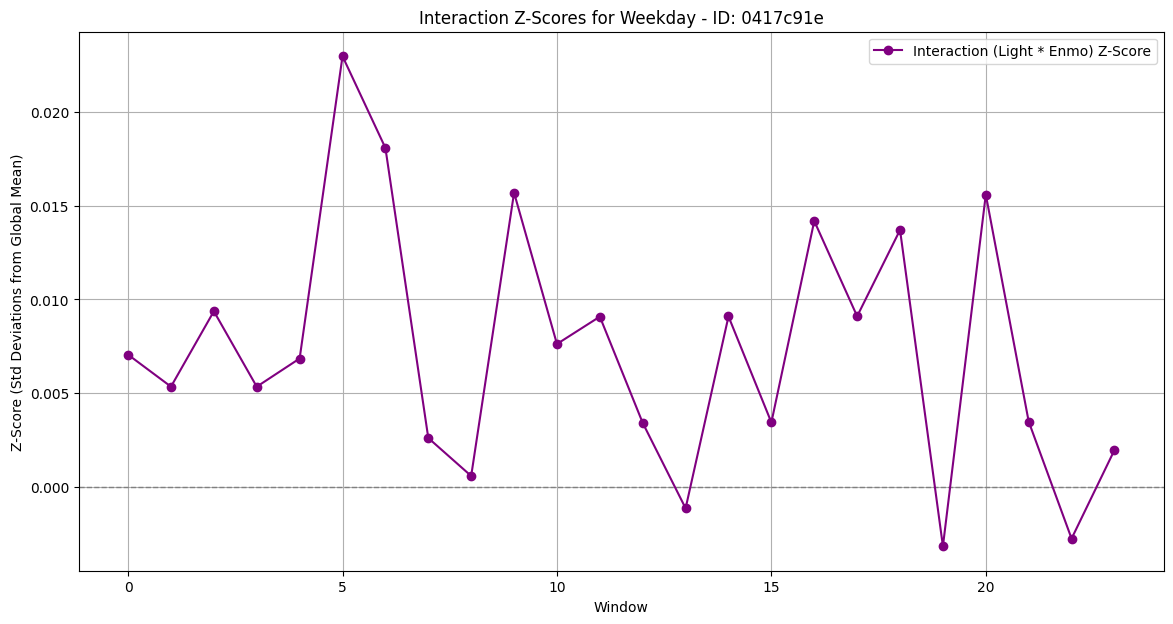

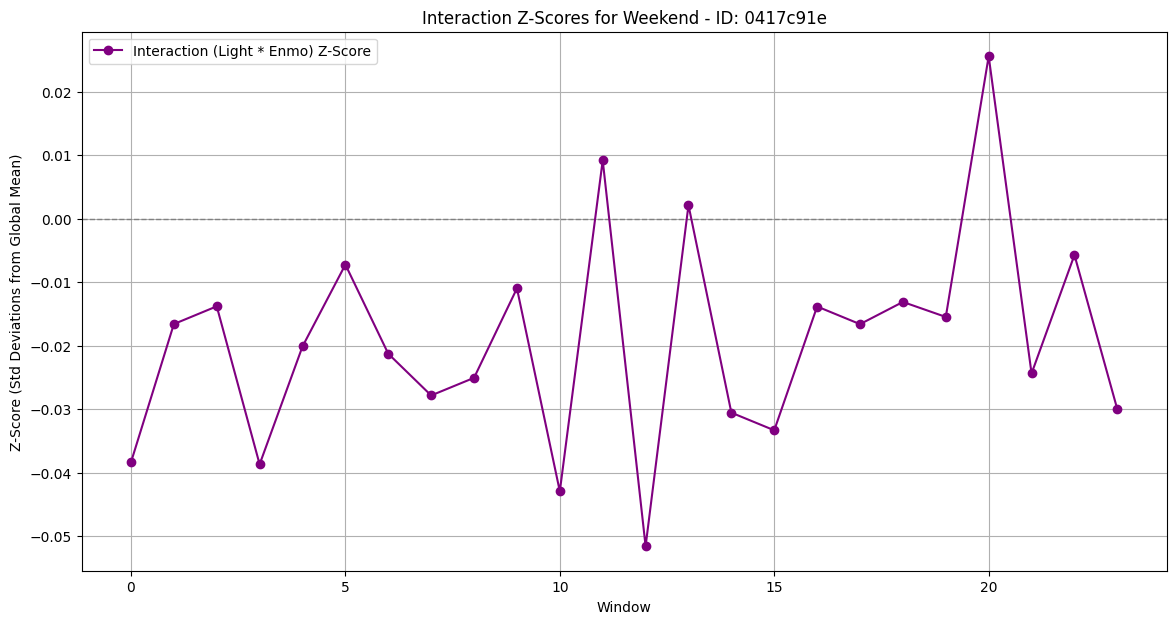

In [40]:
def plot_interaction_z_scores(window_stats_df, specified_id):
    """
    Plots the z-scores of the interaction term (`light * enmo`) for weekdays and weekends for a specified ID.

    Parameters:
    - window_stats_df (DataFrame): DataFrame containing window-level statistics.
    - specified_id (str): The ID for which to plot the z-scores.
    """
    # Filter data for the specified ID
    df_id = window_stats_df[window_stats_df['id'] == specified_id]
    
    if df_id.empty:
        print(f"No data found for ID: {specified_id}")
        return
    
    # Plot z-scores for each time frame (weekday/weekend)
    for time_frame in ['weekday', 'weekend']:
        df_time = df_id[df_id['time_frame'] == time_frame]
        
        plt.figure(figsize=(14, 7))
        plt.title(f"Interaction Z-Scores for {time_frame.capitalize()} - ID: {specified_id}")
        plt.xlabel("Window")
        plt.ylabel("Z-Score (Std Deviations from Global Mean)")
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line

        # Plot interaction z-scores
        df_feature = df_time[df_time['feature'] == 'interaction']
        plt.plot(
            df_feature['window'],
            df_feature['interaction_z_score'],
            label='Interaction (Light * Enmo) Z-Score',
            marker='o',
            color='purple'
        )

        plt.legend()
        plt.grid()
        plt.show()

# Example usage
plot_interaction_z_scores(train_window_stats, '0417c91e')


In [41]:
# Pivot window stats for train and test
def pivot_window_stats(window_stats_df):
    """
    Pivots window stats to have columns like 'metric_timeframe_feature_window#'.
    """
    # Create a unique column name combining metric, time_frame, feature, and window
    window_stats_pivot = window_stats_df.melt(
        id_vars=['id', 'window', 'time_frame', 'feature'],
        var_name='metric',
        value_name='value'
    )
    # Combine metric, time_frame, feature, and window into one column name
    window_stats_pivot['metric_window'] = (
        window_stats_pivot['metric'] + '_' +
        window_stats_pivot['time_frame'] + '_' +
        window_stats_pivot['feature'] + '_window' +
        window_stats_pivot['window'].astype(str)
    )
    
    # Pivot the DataFrame to wide format
    return window_stats_pivot.pivot(index='id', columns='metric_window', values='value').reset_index()

# Pivot train and test window stats
pivoted_train_window_stats = pivot_window_stats(train_window_stats)
pivoted_test_window_stats = pivot_window_stats(test_window_stats)

# Merge pivoted window stats with the combined DataFrames
combined_train = pd.merge(combined_train, pivoted_train_window_stats, on='id', how='left')
combined_test = pd.merge(combined_test, pivoted_test_window_stats, on='id', how='left')


In [42]:
combined_train

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,...,interaction_z_score_weekend_interaction_window21,interaction_z_score_weekend_interaction_window22,interaction_z_score_weekend_interaction_window23,interaction_z_score_weekend_interaction_window3,interaction_z_score_weekend_interaction_window4,interaction_z_score_weekend_interaction_window5,interaction_z_score_weekend_interaction_window6,interaction_z_score_weekend_interaction_window7,interaction_z_score_weekend_interaction_window8,interaction_z_score_weekend_interaction_window9
0,-1.528487,-1.298047,-0.425795,-1.332426,-0.864590,-0.525781,0.639120,0.274162,0.389971,0.387305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.361407,-0.034468,-1.001769,-1.060361,-0.976654,-1.325052,0.390888,-0.902247,0.286795,0.506798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.069637,0.507066,-0.472133,0.095917,-0.285596,0.045127,-0.364600,0.910933,-0.014135,0.028825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.361407,0.507066,-0.138990,0.027901,-0.145516,-0.183236,-0.742345,1.137581,-0.014135,0.865278,...,-0.034019,-0.048639,-0.038194,-0.029598,-0.021758,-0.040594,-0.022180,-0.038972,-0.029608,-0.024680
4,0.805674,-1.388302,0.669236,0.504015,0.568889,0.996641,-0.742345,-0.675600,-0.916924,0.028825,...,-0.065836,-0.060069,-0.052198,-0.059447,-0.054006,-0.028413,-0.062382,-0.047044,-0.031182,-0.065369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,-0.653177,0.494172,-0.372591,-0.448213,-0.481707,-0.525781,-0.742345,-1.279993,-0.315065,-0.090668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2732,-0.944947,0.055788,-1.023777,-0.992344,-0.962646,-1.058628,-0.364600,-0.524501,-0.736367,0.387305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2733,0.805674,-0.485746,-0.530148,0.504015,-0.126839,0.121248,0.088693,-0.902247,-0.796552,-0.329655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2734,0.222133,0.236299,0.499295,0.572032,0.512857,0.463793,0.693083,1.288679,-0.074321,-0.449148,...,-0.052534,-0.051075,-0.048380,-0.051251,-0.049894,-0.049537,-0.045554,-0.045976,-0.048516,-0.052138


# Data Splitting and Scaling

In [43]:
train_df = combined_train
test_df = combined_test

# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=22,
    stratify=y
)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7, weights='uniform')),  # Impute missing values for actigraphy summary stats
    ('scaler', StandardScaler())  # Scale features
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', 'passthrough', categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer (without activation function)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights)
class_weights_tensor = class_weights_tensor.to(device)

In [45]:
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer_skorch = make_scorer(qwk_scorer, greater_is_better=True)

# Determine input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]

def create_pipeline(trial):
    # Define neural network parameters from trial
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    max_epochs = trial.suggest_int('max_epochs', 20, 50)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    hidden_sizes = trial.suggest_categorical('hidden_sizes', [[128, 64], [64, 32]])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])
    
    # Map activation functions
    activation_map = {
        'ReLU': nn.ReLU(),
        'LeakyReLU': nn.LeakyReLU(),
        'ELU': nn.ELU()
    }

    # Configure neural network
    net = NeuralNetClassifier(
        module=MyModule,
        module__inp_size=num_input_features,
        module__hidden_sizes=hidden_sizes,
        module__nonlin=activation_map[activation],
        module__dropout=dropout,
        max_epochs=max_epochs,
        lr=lr,
        optimizer=torch.optim.Adam if optimizer_name == 'Adam' else torch.optim.SGD,
        criterion=torch.nn.CrossEntropyLoss(),
        criterion__weight=class_weights_tensor,
        batch_size=256,
        iterator_train__shuffle=True,
        device=device,
        verbose=0,
    )

    # Add momentum for SGD
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        net.set_params(optimizer__momentum=momentum)

    return Pipeline([
        ('preprocessor', preprocessor),
        ('to_float32', to_float32),
        ('nn', net)
    ])

def objective(trial):
    pipeline = create_pipeline(trial)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)
    scores = cross_val_score(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv,
        scoring=qwk_scorer_skorch,
        n_jobs=-1
    )
    return scores.mean()

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Get best pipeline
best_pipeline = create_pipeline(study.best_trial)
best_pipeline.fit(X_train, y_train)

print(f"Best score: {study.best_value:.4f}")
print("Best hyperparameters:", study.best_params)

[I 2024-12-10 17:07:46,531] A new study created in memory with name: no-name-5ba6b648-f93e-4897-a97b-66b08874ef0d
c:\Users\Ethan Wong\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64] which is of type list.
  warnings.warn(message)
c:\Users\Ethan Wong\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64] which is of type list.
  warnings.warn(message)
c:\Users\Ethan Wong\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 32] which is of type lis

Best score: 0.9465
Best hyperparameters: {'lr': 0.001648696745434855, 'max_epochs': 46, 'dropout': 0.291023220955836, 'hidden_sizes': [128, 64], 'optimizer': 'Adam', 'activation': 'ELU'}


In [46]:
best_params = study.best_params
best_params

{'lr': 0.001648696745434855,
 'max_epochs': 46,
 'dropout': 0.291023220955836,
 'hidden_sizes': [128, 64],
 'optimizer': 'Adam',
 'activation': 'ELU'}

# Evaluating Skorch NN

In [51]:
# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.9088

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       319
           1       0.86      0.86      0.86       146
           2       0.81      0.87      0.84        76
           3       0.44      0.57      0.50         7

    accuracy                           0.91       548
   macro avg       0.77      0.81      0.79       548
weighted avg       0.91      0.91      0.91       548



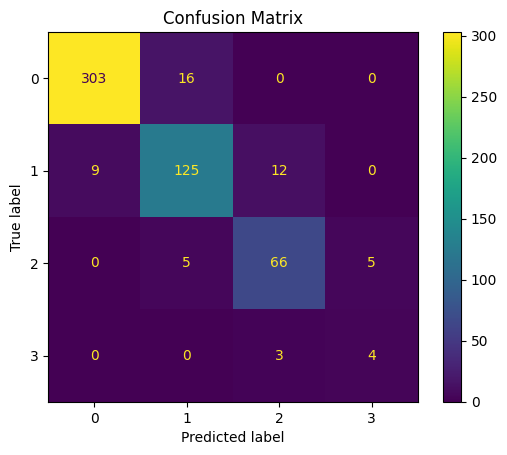

In [52]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

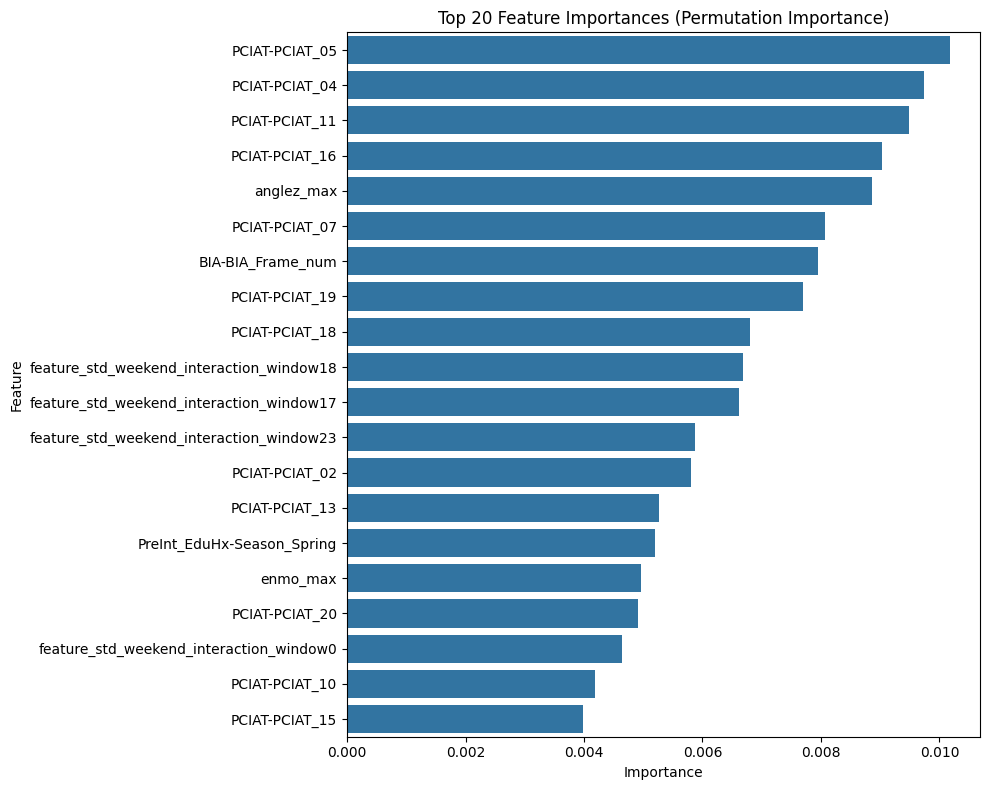

In [54]:
def qwk_scorer_fi(estimator, X, y):
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred, weights='quadratic')

# Compute feature importances on the validation set
result = permutation_importance(
    best_pipeline, X_val, y_val, n_repeats=10, scoring=qwk_scorer_fi, random_state=22, n_jobs=1
)

# Get the feature names after preprocessing
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if transformer == 'passthrough':
            feature_names.extend(cols)
        elif transformer == 'drop':
            continue
        else:
            # For numerical features, get the output feature names
            transformer_steps = transformer.named_steps
            if 'onehot' in transformer_steps:
                # For OneHotEncoder
                encoder = transformer_steps['onehot']
                feature_names.extend(encoder.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)
    return feature_names

feature_names = get_feature_names(best_pipeline.named_steps['preprocessor'])

# Get the importances
importances = result.importances_mean

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances (Permutation Importance)')
plt.tight_layout()
plt.show()

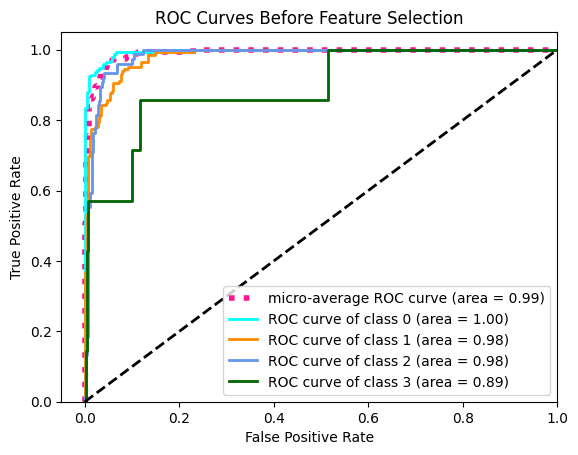

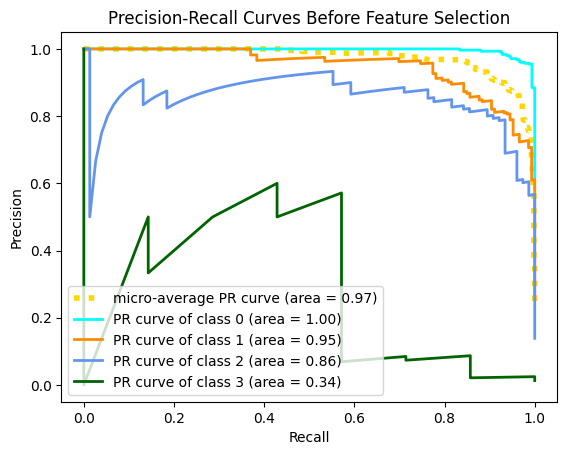

In [59]:
# Obtain the predicted probabilities for the validation set
y_val_proba = best_pipeline.predict_proba(X_val)

# Binarize the output labels
y_val_binarized = label_binarize(y_val, classes=classes)

# For each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    pr_auc[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_binarized.ravel(), y_val_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average PR curve and PR area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
pr_auc["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Before Feature Selection')
plt.legend(loc="lower right")
plt.show()

# Plot all PR curves
plt.figure()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average PR curve (area = {0:0.2f})'
               ''.format(pr_auc["micro"]),
         color='gold', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], pr_auc[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Before Feature Selection')
plt.legend(loc="lower left")
plt.show()

# Feature Selection - Filter Method

In [60]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    col_name = []

    for name, transformer, cols in column_transformer.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            # Just pass through these columns
            col_name.extend(cols)
        else:
            # If it's a pipeline, get the last step
            if hasattr(transformer, 'steps'):
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names_out'):
                col_name.extend(transformer.get_feature_names_out(cols))
            else:
                col_name.extend(cols)

    return col_name

In [61]:
def create_pipeline(input_size, study_best_params):
    # Extract parameters from study_best_params
    lr = study_best_params['lr']
    max_epochs = study_best_params['max_epochs']
    dropout = study_best_params['dropout']
    hidden_sizes = study_best_params['hidden_sizes']
    optimizer_str = study_best_params['optimizer']
    activation_str = study_best_params['activation']

    # Convert activation string to actual activation function
    if activation_str == 'ELU':
        nonlin = nn.ELU()
    elif activation_str == 'ReLU':
        nonlin = nn.ReLU()
    elif activation_str == 'LeakyReLU':
        nonlin = nn.LeakyReLU()
    else:
        nonlin = nn.ReLU()  # default fallback

    # Convert optimizer string to actual optimizer class
    if optimizer_str == 'Adam':
        optimizer_cls = torch.optim.Adam
    elif optimizer_str == 'SGD':
        optimizer_cls = torch.optim.SGD
    else:
        optimizer_cls = torch.optim.Adam  # default fallback

    # Prepare parameters for NeuralNetClassifier
    nn_params = {
        'max_epochs': max_epochs,
        'lr': lr,
        'optimizer': optimizer_cls
    }

    module_params = {
        'inp_size': input_size,
        'hidden_sizes': hidden_sizes,
        'dropout': dropout,
        'nonlin': nonlin
    }

    optimizer_params = {}  # No additional optimizer params from study

    net = NeuralNetClassifier(
        module=MyModule,
        # Module parameters
        **{f'module__{k}': v for k, v in module_params.items()},
        # Optimizer parameters
        **{f'optimizer__{k}': v for k, v in optimizer_params.items()},
        # NN parameters
        **nn_params,
        criterion=torch.nn.CrossEntropyLoss(),
        criterion__weight=class_weights_tensor,
        batch_size=256,
        iterator_train__shuffle=True,
        device=device,
        verbose=0,
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('to_float32', to_float32),
        ('nn', net)
    ])
    return pipeline

In [62]:
# Transform X_train and X_val using the preprocessor
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Get feature names after preprocessing
feature_names = get_feature_names(preprocessor)

In [63]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_train_processed, y_train, random_state=22)
mi_scores_dict = dict(zip(feature_names, mi_scores))
sorted_features = sorted(mi_scores_dict.items(), key=lambda x: x[1])

# Initialize baseline score
num_input_features = X_train_processed.shape[1]
pipeline = create_pipeline(num_input_features, best_params)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)
baseline_scores = cross_val_score(
    pipeline, X_train, y_train, cv=cv, scoring=qwk_scorer_skorch, n_jobs=-1
)
baseline_score = baseline_scores.mean()
print(f"Baseline Cross-Validated QWK Score: {baseline_score:.4f}")

Baseline Cross-Validated QWK Score: 0.9414


In [64]:
# Iteratively remove features
features_to_remove = []
current_features = feature_names.copy()
current_score = baseline_score

for feature, score in sorted_features:
    current_features.remove(feature)

    current_numerical_cols = [col for col in numerical_cols if col in current_features]
    current_categorical_cols = [col for col in categorical_cols if col in current_features]
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, current_numerical_cols),
        ('cat', 'passthrough', current_categorical_cols)
    ])
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    input_size = X_train_processed.shape[1]
    pipeline = create_pipeline(input_size, best_params)

    scores = cross_val_score(
        pipeline, X_train, y_train, cv=cv, scoring=qwk_scorer_skorch, n_jobs=-1
    )
    mean_score = scores.mean()

    if mean_score >= current_score:
        features_to_remove.append(feature)
        current_score = mean_score
    else:
        current_features.append(feature)

print(f"\nFeatures to remove: {features_to_remove}")


Features to remove: ['Basic_Demos-Enroll_Season_Winter', 'interaction_z_score_weekday_interaction_window12']


In [65]:
# Retrain final model
final_numerical_cols = [col for col in numerical_cols if col not in features_to_remove]
final_categorical_cols = [col for col in categorical_cols if col not in features_to_remove]
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, final_numerical_cols),
    ('cat', 'passthrough', final_categorical_cols)
])
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
input_size = X_train_processed.shape[1]
pipeline = create_pipeline(input_size, best_params)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=7)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Basic_Demos-Age',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fitness...
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (net): Sequential(
      (0): Linear(in_features=245, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.291023220955836, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ELU(alpha=1.0)
      (5): Dropout(p=0.291023220955836, inplace=False)
      (6): Linear(in_features=64, out_features=4, bias=True)
    )
  ),
))])


Validation QWK Score after Feature Selection: 0.9025

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       319
           1       0.84      0.88      0.86       146
           2       0.84      0.80      0.82        76
           3       0.29      0.57      0.38         7

    accuracy                           0.90       548
   macro avg       0.74      0.80      0.76       548
weighted avg       0.91      0.90      0.91       548



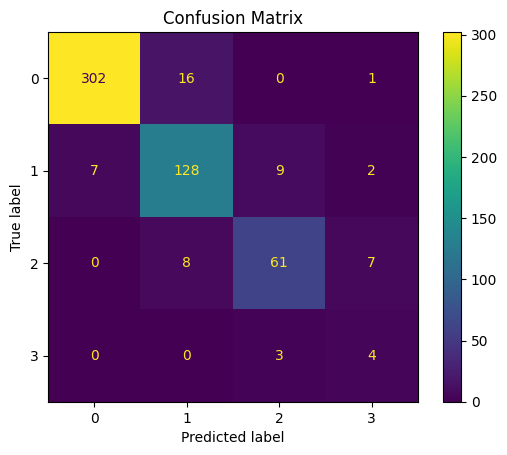

In [66]:
# Evaluate on validation set
y_val_pred = pipeline.predict(X_val)
val_qwk = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print(f"\nValidation QWK Score after Feature Selection: {val_qwk:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

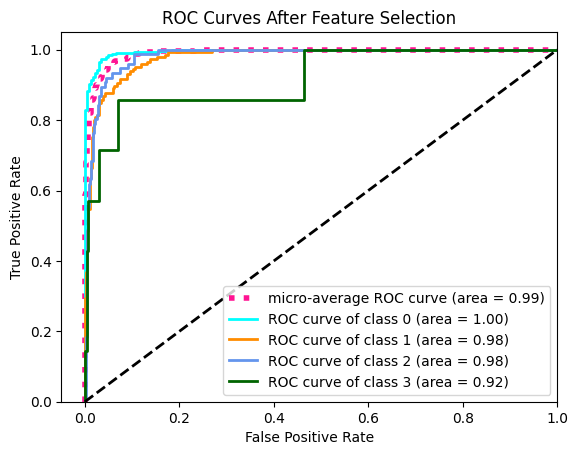

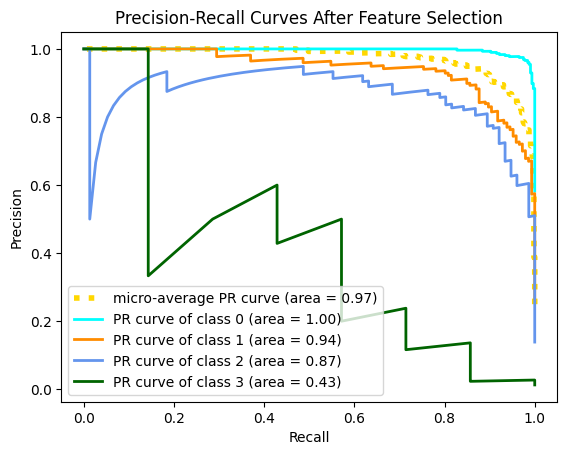

In [69]:
# Obtain the predicted probabilities for the validation set after feature selection
y_val_proba_fs = pipeline.predict_proba(X_val)

fpr_fs = dict()
tpr_fs = dict()
roc_auc_fs = dict()
precision_fs = dict()
recall_fs = dict()
pr_auc_fs = dict()

for i in range(len(classes)):
    fpr_fs[i], tpr_fs[i], _ = roc_curve(y_val_binarized[:, i], y_val_proba_fs[:, i])
    roc_auc_fs[i] = auc(fpr_fs[i], tpr_fs[i])

    precision_fs[i], recall_fs[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba_fs[:, i])
    pr_auc_fs[i] = average_precision_score(y_val_binarized[:, i], y_val_proba_fs[:, i])

fpr_fs["micro"], tpr_fs["micro"], _ = roc_curve(y_val_binarized.ravel(), y_val_proba_fs.ravel())
roc_auc_fs["micro"] = auc(fpr_fs["micro"], tpr_fs["micro"])

precision_fs["micro"], recall_fs["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba_fs.ravel())
pr_auc_fs["micro"] = average_precision_score(y_val_binarized, y_val_proba_fs, average="micro")

plt.figure()
plt.plot(fpr_fs["micro"], tpr_fs["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_fs["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr_fs[i], tpr_fs[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc_fs[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves After Feature Selection')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall_fs["micro"], precision_fs["micro"],
         label='micro-average PR curve (area = {0:0.2f})'
               ''.format(pr_auc_fs["micro"]),
         color='gold', linestyle=':', linewidth=4)

for i, color in zip(range(len(classes)), colors):
    plt.plot(recall_fs[i], precision_fs[i], color=color, lw=2,
             label='PR curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], pr_auc_fs[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves After Feature Selection')
plt.legend(loc="lower left")
plt.show()

# Predicting the Test Set

In [70]:
X_test_processed = preprocessor.transform(X_test)
y_test_pred = pipeline.predict(X_test)
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})

output_df

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,1
4,0016bb22,3
5,001f3379,0
6,0038ba98,0
7,0068a485,1
8,0069fbed,1
9,0083e397,3


In [ ]:
#output_df.to_csv('submission.csv', index = False)